$\Huge{\text{Modelisation du cours du BITCOIN}}$

<hr><b>
<hr><b>

$\huge{\text{Groupe KAGLAN KHABITIE KHENESSI}}$

## Imports and set up

##### Remarque : Le module arch est appellé dans les imports. Il faudra l'installer avec la commande !pip install arch 

In [2]:
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.collections import PolyCollection
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from arch.unitroot import ADF
plt.rcParams['figure.figsize']=(10,8)
plt.rc('axes', labelsize = 15)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.style.use('seaborn-whitegrid')

# Data Exploration and Analysis

### Cours de Cloture du BITCOIN sur 10 ans (du 23-12-2011 au 23-12-2021 )

In [3]:
!wget https://minio.lab.sspcloud.fr/mawulikaglan/BTCEUR.txt
!ls

--2022-01-03 14:18:22--  https://minio.lab.sspcloud.fr/mawulikaglan/BTCEUR.txt
Resolving minio.lab.sspcloud.fr (minio.lab.sspcloud.fr)... 192.168.253.151, 192.168.253.152
Connecting to minio.lab.sspcloud.fr (minio.lab.sspcloud.fr)|192.168.253.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 176263 (172K) [binary/octet-stream]
Saving to: ‘BTCEUR.txt.1’

BTCEUR.txt.1        100%[===================>] 172.13K  --.-KB/s    in 0.003s  

2022-01-03 14:18:22 (61.6 MB/s) - ‘BTCEUR.txt.1’ saved [176263/176263]

 BTCEUR.txt
 BTCEUR.txt.1
'Charles-Travail de modelisation .ipynb'
 DM_Figures
 Modelisation.ipynb
'Notebook DataScience Project.ipynb'
'Notebook DataScience Project - Webscrapping.ipynb'


#### Importation des données :

In [4]:
BTC = pd.read_csv('BTCEUR.txt', sep="\t", parse_dates=[0], index_col=0)

In [5]:
for x in BTC:
    print(x)

ouv
haut
bas
clot
vol
devise
Unnamed: 7


In [7]:
Close = BTC['clot']

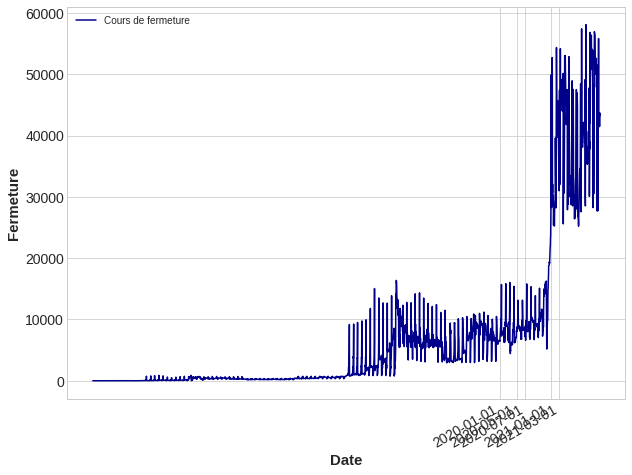

In [8]:
Close.plot(color='darkblue', label='Cours de fermeture')
plt.xticks([18262. ,18383., 18444.,  18687.,18628])
plt.ylabel('Fermeture', fontdict={'weight':'bold'})
plt.xlabel('Date',fontdict={'weight':'bold'})
plt.legend()

### Serie des log-returns

In [10]:
logrets=Close.pct_change().apply(lambda x: np.log(1 + x)).dropna()

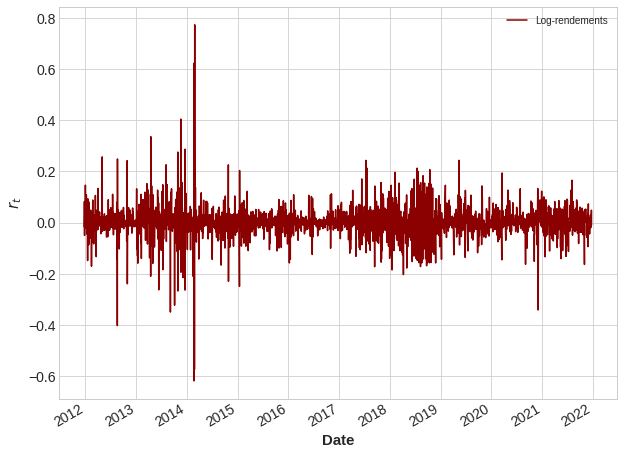

In [11]:
logrets.plot(color='darkred', label='Log-rendements')
plt.ylabel(r'$r_t$', fontdict={'weight':'bold'})
plt.xlabel('Date',fontdict={'weight':'bold'})
plt.legend()

#### Observation de la queue et de la tête des données de log-rendements

In [12]:
lrets_train = logrets.copy()
lrets_train.tail(), lrets_train.head()

(date
 2021-12-16   -0.019449
 2021-12-17   -0.019345
 2021-12-20    0.003368
 2021-12-21    0.048755
 2021-12-22   -0.009245
 Name: clot, dtype: float64,
 date
 2011-12-24   -0.016421
 2011-12-25    0.082587
 2011-12-26   -0.050010
 2011-12-27   -0.003210
 2011-12-28    0.053221
 Name: clot, dtype: float64)

### Statistiques descriptives et préliminaires à la modelisation

#### Statistiques descriptives

In [13]:
lrets_train.describe()

count    3306.000000
mean        0.002890
std         0.055802
min        -0.618224
25%        -0.013446
50%         0.002558
75%         0.021303
max         0.773201
Name: clot, dtype: float64

In [14]:
Sk = stats.skew
K = stats.kurtosis

In [15]:
Sk(lrets_train), K(lrets_train), K(lrets_train)-3

(0.32146739614713016, 29.178350410807774, 26.178350410807774)

#### Etude de la Normalité des log-returns

In [16]:
stats.shapiro(lrets_train)

ShapiroResult(statistic=0.790280282497406, pvalue=0.0)

In [17]:
stats.jarque_bera(lrets_train)

Jarque_beraResult(statistic=117334.0033278772, pvalue=0.0)

In [18]:
stats.kstest(lrets_train, 'norm')

KstestResult(statistic=0.43165969261377113, pvalue=0.0)

#### Fonction de densité empirique de la série des log-returns (KDE)

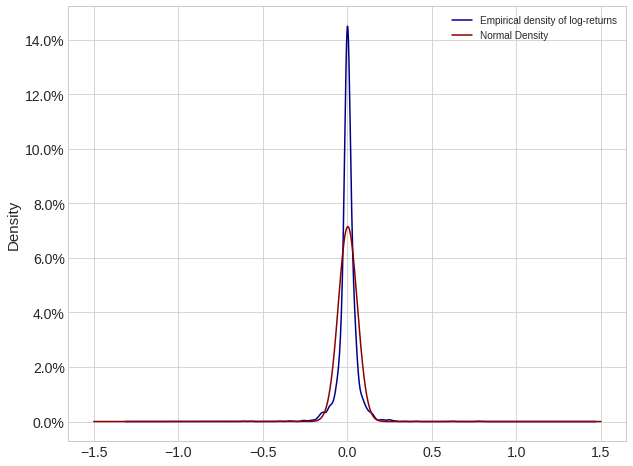

In [19]:
lrets_train.plot(kind='kde', color='darkblue', label='Empirical density of log-returns')
plt.yticks(plt.yticks()[0],[str(x)+'%' for x in plt.yticks()[0]])
x=np.linspace(-1.5, 1.5, len(lrets_train))
plt.plot(x, stats.norm.pdf(x, lrets_train.mean(), lrets_train.std()), color='darkred', label='Normal Density')
plt.legend()

#### Fonction de répartition empirique de la série de log returns

In [20]:
p = stats.norm.fit(lrets_train)

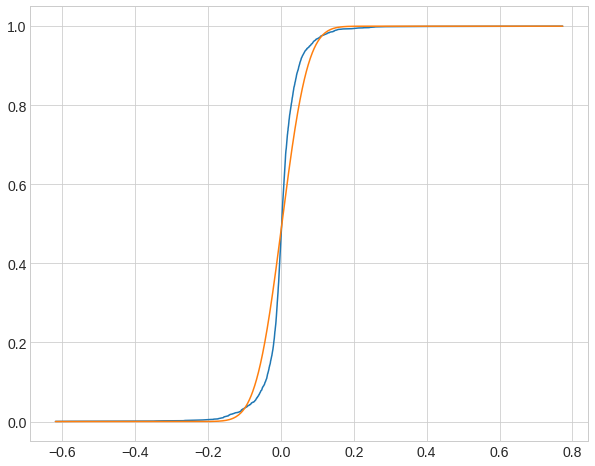

In [21]:
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(lrets_train)
x = ecdf.x
plt.plot(x, ecdf.y)
plt.plot(x, stats.norm.cdf(x, *p))

#### Diagrams QQ-plot of log-returns

(-4.0, 4.0)

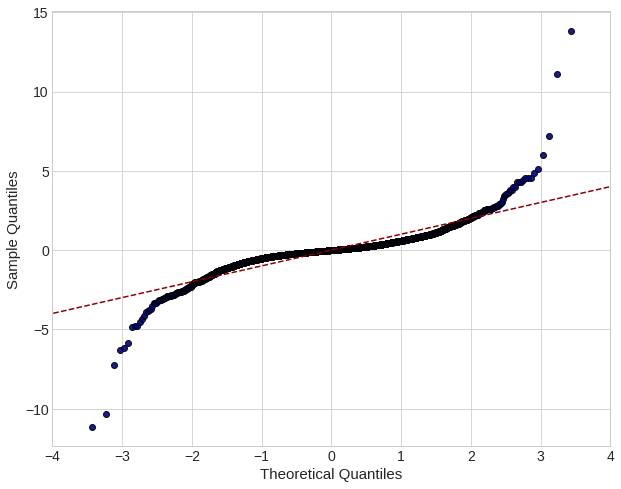

In [ ]:
import statsmodels.api as sm
pp = sm.ProbPlot(lrets_train, fit=True)
qq = pp.qqplot(marker='o', markerfacecolor='darkblue', markeredgecolor='k', alpha=0.9)
sm.qqline(qq.axes[0], line='45', color='darkred', linestyle='dashed')
plt.xlim((-4,4))

#### Analyse de la stationarité : Test des Dickey-Fuller Augmenté (ADF-Augmented Dickey-Fuller Test)

##### Remarque : Il faut ici avoir d'abord installé le module arch avec la commande !pip install arch 

In [23]:
from arch.unitroot import ADF
trends = ['ct', 'c', 'n']
for t in trends:
    r=ADF(lrets_train, trend=t)
    print(r,'\n')

   Augmented Dickey-Fuller Results   
Test Statistic                 -9.961
P-value                         0.000
Lags                               27
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.96 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

   Augmented Dickey-Fuller Results   
Test Statistic                 -9.950
P-value                         0.000
Lags                               27
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

   Augmented Dickey-Fuller Results   
Test Statistic                 -9.620
P-value                         0.000
Lags                               27
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), 

#### Fonction d'autocorrélation partiel et Fonction d'autocorrélation (ACF /PACF )

In [36]:
def AcfPacf(data, model=''):
    fig, ax = plt.subplots(2)
    smt.graphics.plot_acf(data, ax=ax[0], color='darkblue', vlines_kwargs={'linewidth':3,'color':'darkblue'});
    smt.graphics.plot_pacf(data, ax=ax[1], color='darkblue', vlines_kwargs={'linewidth':3,'color':'darkblue'});
    for item, itemm in zip(ax[0].collections, ax[1].collections):
        if ((type(item)==PolyCollection) & (type(itemm)==PolyCollection)) :
            item.set_facecolor('darkred')
            itemm.set_facecolor('darkred')
    ax[0].set_title('ACF' +model,fontdict={'weight':'bold'})
    ax[1].set_title('PACF' +model,fontdict={'weight':'bold'})
    return None

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


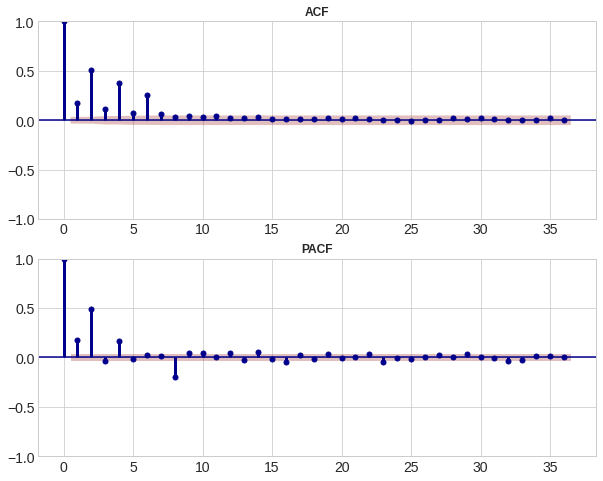

In [34]:
AcfPacf((lrets_train)**2)

### Lag-plots

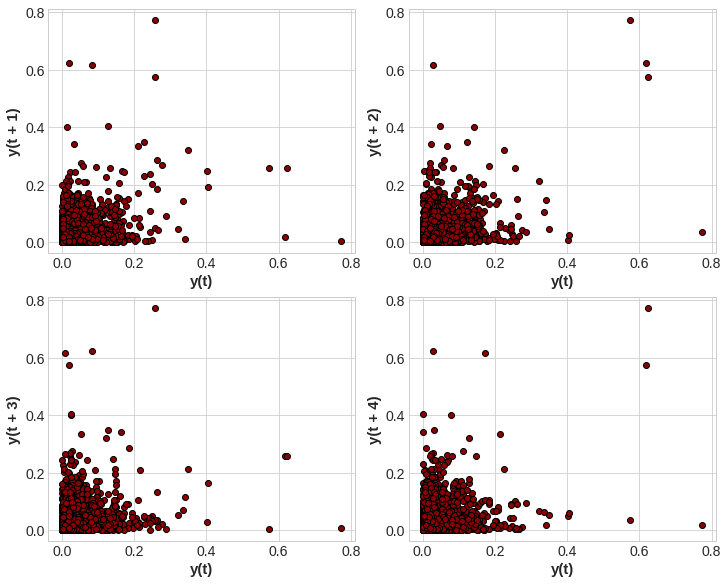

In [31]:
fig, axs = plt.subplots(2,2, constrained_layout=True)
plt.rc('axes', labelweight='bold')
plt.rcParams['patch.facecolor']='darkred'

for i in range(2):
    for j in range(2):
        pd.plotting.lag_plot(np.abs(lrets_train), 2*i+j+1, ax=axs[i,j], edgecolor='black')

789  : ( -0.0821 , -0.6182  )
------------------------------
790  : ( -0.6182 , -0.0192  )
------------------------------
791  : ( -0.0192 , 0.6239  )
------------------------------
792  : ( 0.6239 , 0.2569  )
------------------------------
793  : ( 0.2569 , -0.5735  )
------------------------------
794  : ( -0.5735 , 0.2574  )
------------------------------
795  : ( 0.2574 , 0.7732  )
------------------------------


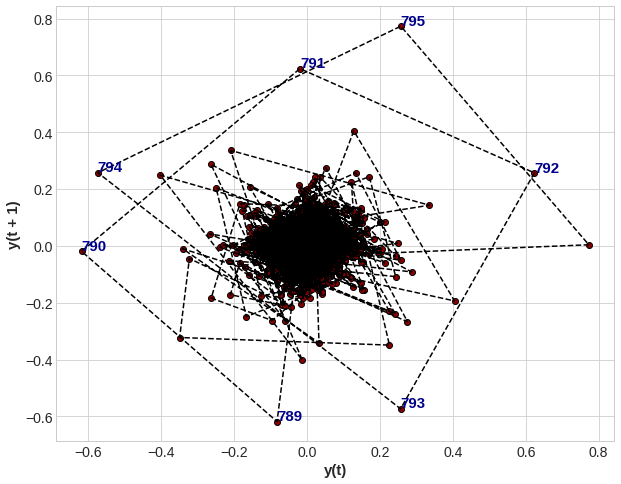

In [27]:
plt.rcParams['patch.facecolor']='darkred'
plt.plot(lrets_train.shift(1), lrets_train,'k--')
pd.plotting.lag_plot(lrets_train, 1, edgecolor='black')
for i in range(789,796):
    plt.annotate(str(i), (lrets_train.shift(1)[i], lrets_train[i]+0.004),fontweight='bold',fontsize=15, color='darkblue')
    print(str(i),' : ( %.4f' % lrets_train.shift(1)[i],', %.4f ' %lrets_train[i],')\n------------------------------')
#save_fig('Volat_Clust')    

# Modelisation et Prevision (Forecasting)

### La prévision par lissage exponentiel (Exponential smoothing )

In [28]:
ES = smt.ExponentialSmoothing
SES = smt.SimpleExpSmoothing


**(1-$\alpha$) Conf-int** : 

$[$ $z_{\alpha}$ : $\alpha$ quantile of the standard normal dist, $\beta$ : smoothing parameter ($\beta = 1-\gamma$ where $\gamma$ is the smoothing param in Python)$]$

- **SES** :  $ [ \ \hat{r}_t(h) - z_{1-\frac{\alpha}{2}}\ \sigma_r C(h, \beta),\  \hat{r}_t(h) + z_{1-\frac{\alpha}{2}}\ \sigma_r C(h, \beta) \  ]$ where : $$C^2(h, \beta)= 1 + \frac{1-\beta}{(1+\beta)^3} \left[(1+4\beta + 5\beta^2) + 2h(1-\beta)(1+3\beta) + 2h^2(1-\beta)^2 \right] $$

In [ ]:
import warnings
warnings.filterwarnings('ignore')

class ExpSmooth:
    def __init__(self, data):
        self.data = data
        return None

    def __C(self, h, beta):
        return 1 + ((1-beta)/(1+beta**3))*(1+4*beta+5*beta**2 + 2*h*(1-beta)*(1+3*beta) + 2*(h**2)*(1-beta)**2)

    def __ConfInt(self, forecasts, beta,  method, horizon, alpha=.05):
        idx = forecasts.index[0]
        ci = []
        sigma = self.data.std()
        z = stats.norm.ppf(1-alpha/2)
        for h in range(horizon):
            ci.append([forecasts[idx + h]-z*sigma*np.sqrt(self.__C(h, beta)),forecasts[idx + h]+z*sigma*np.sqrt(self.__C(h, beta))])
        return pd.DataFrame(ci, columns=['down', 'up'])

    def SES(self, forecasts_horizon=1):
        ses_fit = SES(self.data, initialization_method='estimated').fit()
        ses_forecasts = ses_fit.forecast(forecasts_horizon).rename(r'$\beta = %s$'%np.round(1 - ses_fit.params['smoothing_level'], 3))
        beta = 1-ses_fit.params['smoothing_level']
        return ses_fit, ses_forecasts, self.__ConfInt(ses_forecasts, beta= beta, method='SES', horizon=forecasts_horizon)